# Propagation of the selected cases using SWAN

The cases are already selected and now, these selected cases must be propagated to shallow water so the wave climate can be reconstructed in the desired coast.

The propagation of the cases is not performed equally for the windeas and the swells, as it was described in the MDA notebook. When the windseas are propagated, wind is taken into account and the parameter $\gamma$ (named as _jonswap_gamma_ or _ws.gamma_ in the code) takes a constant value of 3. On the other hand, swells are propagated without the effect of the local wind, and its shape parameter $\gamma$ depends on each individual case. For this purpose, the only thing that must be done so the propagations can run correctly is change the <code>make_input</code> function in the <code>io.py</code> file as it is shown below:

![io.py](../images/swan/io-file-examples.png)

Notice that the <code>io.py</code> file is loaded as a module, so once the seas have been run, the kernel must be restarted, and all the modules must be reloaded again. Run the seas by running all the cells below until the <b>advice</b> cell in blue appears, and then repeat the process for the swells, changing the <code>io.py</code> file first.

A very important fact in this propagation section is the computational effort that is made, and which is translated into time. The software that is used here is proportioned by the [Technical Univerity of Delft](https://www.tudelft.nl/) and is called [SWAN](http://swanmodel.sourceforge.net/) (Simulating WAves Nearshore). With SWAN, each individual case is propagated dinamically to each cell or point in the bathymetry grid, resolving phenomenons such as diffraction and refraction. This is very expensive at the computational level, so just a certain number of cases are propagated that will be used later to reconstruct the total historical dataset.

<font color=red>Time wasted running the cases: </font> The time depends on the number of cases that wanna be run and the shape of the bathymetry or region desired, as it is obvious, but as a reference, __100 windseas__ cases can take a time of about __3 hours__ while __100 swells__ can be resolved in __1 hour__, a third of the time.

## Windseas can be run below

\begin{equation*}
\textit{Windseas: } \:\: H_S \:\: T_P \:\: \theta_m \:\: \sigma_\theta \:\: W \:\: \theta_W
\end{equation*}

In [1]:
# common 
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from time import time

import warnings
warnings.filterwarnings("ignore")

t0 = time()

# swan wrap module
from lib.wrap import SwanProject, SwanWrap_STAT

In [2]:
# data
num_cases = 20
p_data = op.abspath(op.join(os.getcwd(), '..', 'data'))
p_hind = op.join(p_data, 'hindcast')
waves = pd.read_pickle(op.join(p_hind, 'sea_cases_'+str(num_cases)+'.pkl'))

waves.rename(columns={'Hsea'   : 'hs',
                      'Tpsea'  : 'per',
                      'Dirsea' : 'dir',
                      'Sprsea' : 'spr',
                      'W'      : 'vel',
                      'DirW'   : 'dirw'}, inplace=True)

print(waves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hs      20 non-null     float64
 1   per     20 non-null     float64
 2   dir     20 non-null     float64
 3   spr     20 non-null     float64
 4   vel     20 non-null     float64
 5   dirw    20 non-null     float64
dtypes: float64(6)
memory usage: 1.1 KB
None


### <font color=red>EDIT SECTION BELOW:</font>

Here, the grid where the bathymetry will be run is selected. Notice that the file used for this bathymetry is not the global file proportioned by GEBCO, but a regional file that can be also downloaded from the application in this [website](https://www.gebco.net/). An example of the aspect of this application in the region selected in this notebook is shown below:

![GEBCO](../images/swan/gebco-example.png)

As a recommendation, download a bigger area than the one that wants to be used, as the file size will not be much larger, but it is better to ensure the area you are selecting is valid enough.

In [3]:
# --------------------------------------------------------------------------- #
# GRID PARAMETERS
# --------------------------------------------------------------------------- #
# ----------------  EDIT ONLY THIS PART  ------------------------------------ #
# --------------------------------------------------------------------------- #
name = 'CAN' # please choose a short name (max 3 letters)
# Coordinates section
# Place the coordinates as they are proportioned in Google Maps
ini_lon = -3.9
end_lon = -3.6
ini_lat = 43.35
end_lat = 43.55
# --------------------------------------------------------------------------- #
# ----------------  END EDIT  ----------------------------------------------- #

In [4]:
# --------------------------------------------------------------------------- #
# depth auto-selection
p_depth = op.join(p_data, 'bathymetry', 'gebco_2020_n44.0_s43.0_w-4.5_e-2.5.nc') # downloaded bathy
depth = xr.open_dataset(p_depth)
depth = depth.sel(lat=slice(ini_lat,end_lat)).sel(lon=slice(ini_lon,end_lon))
x_point = len(depth.lon.values)
y_point = len(depth.lat.values)
resolution = round(abs(end_lon - ini_lon) / x_point, 4)

(-3.9000000000000057,
 -3.5999999999999943,
 43.349999999999994,
 43.54999999999998)

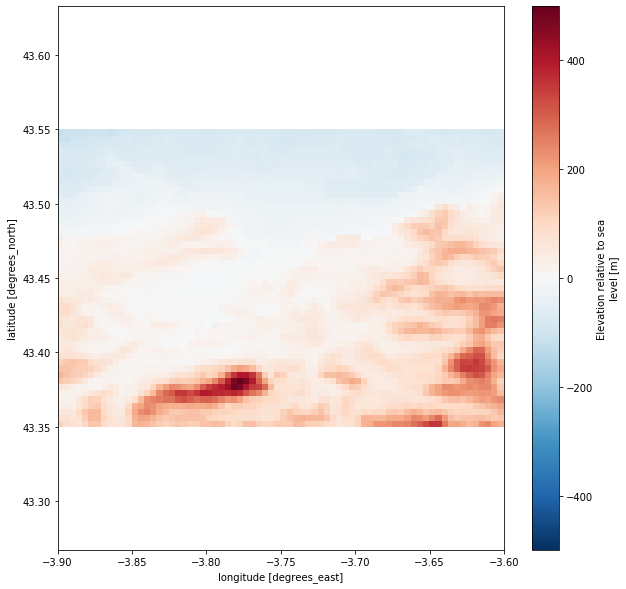

In [5]:
plt.figure(figsize=(10,10))
depth.elevation.plot()
plt.axis('equal')

The bathymetry will have the shape: 

Points in the longitude axis: 72
Points in the latitude axis: 48


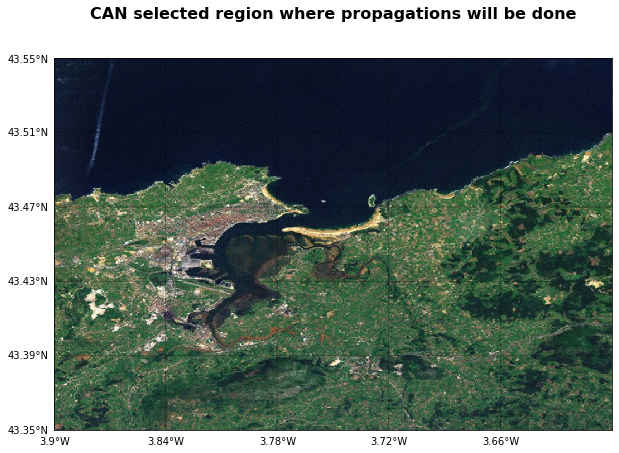

In [6]:
# Figure intialization
plt.figure(figsize=(10,10))
plt.title(name + ' selected region where propagations will be done',
          fontsize=16, fontweight='bold', pad=40)

# Plot the Basemap
m = Basemap(llcrnrlon=ini_lon,  llcrnrlat=ini_lat, 
            urcrnrlon=end_lon, urcrnrlat=end_lat, 
            resolution='l')
 
# Then add element: draw coast line, map boundary, and fill continents:
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000) # becareful with adding xpixels
grid_step_lon = round(abs(end_lon - ini_lon) / 5, 3)
grid_step_lat = round(abs(end_lat - ini_lat) / 5, 3)
m.drawmeridians(np.arange(ini_lon, end_lon+grid_step_lon, grid_step_lon), 
                linewidth=0.5, labels=[1,0,0,1])
m.drawparallels(np.arange(ini_lat, end_lat+grid_step_lat, grid_step_lat), 
                linewidth=0.5, labels=[1,0,0,1])

print('The bathymetry will have the shape: \n')
print('Points in the longitude axis: ' + str(x_point))
print('Points in the latitude axis: ' + str(y_point))

### <font color=red>RUN THE WINDSEAS IN THE CELL BELOW</font>

In [7]:
# --------------------------------------------------------------------------- #
# SWAN project 
p_proj = op.join(p_data, 'projects-swan')    # swan projects main directory
n_proj = name + '-SEA-' + str(resolution)    # project name

sp = SwanProject(p_proj, n_proj)

# depth grid description (input bathymetry grid)
sp.mesh_main.dg = {
    'xpc': ini_lon,            # x origin
    'ypc': ini_lat,            # y origin
    'alpc': 0,                 # x-axis direction 
    'xlenc': end_lon-ini_lon,  # grid length in x
    'ylenc': end_lat-ini_lat,  # grid length in y
    'mxc': x_point-1,          # number mesh x
    'myc': y_point-1,          # number mesh y
    'dxinp': resolution,       # size mesh x
    'dyinp': resolution,       # size mesh y
}

# depth swan init
sp.mesh_main.depth = - depth.elevation.values

# computational grid description
sp.mesh_main.cg = {
    'xpc': ini_lon,
    'ypc': ini_lat,
    'alpc': 0,
    'xlenc': end_lon-ini_lon,
    'ylenc': end_lat-ini_lat,
    'mxc': x_point,
    'myc': y_point,
    'dxinp': resolution,
    'dyinp': resolution,
}

# SWAN parameters (sea level, jonswap gamma)
sp.params = {
    'sea_level': 0,
    'jonswap_gamma': 3,
    'cdcap': None,
    'coords_spherical': None,
    'waves_period': 'PEAK',
    'maxerr': None,
}

# SWAN wrap STAT (create case files, launch SWAN num. model, extract output)
sw = SwanWrap_STAT(sp)

# build stationary cases from waves data
sw.build_cases(waves)

# run SWAN
sw.run_cases()

# extract output from main mesh 
waves_propagated = sw.extract_output()

# save to netCDF file and cases propagated to dataframe
waves.to_pickle(op.join(p_proj, n_proj, 'sea_cases_'+str(num_cases)+'.pkl'))
waves_propagated.to_netcdf(op.join(p_proj, n_proj, 'sea_propagated_'+str(num_cases)+'.nc'))

print('Time transcurred: ' + str(round((time()-t0)/3600, 2)) + ' h')

SWAN CASE: 0000 ---> hs   13.36, per   15.88, dir  293.00, spr   24.10
SWAN CASE: 0001 ---> hs    0.19, per    1.95, dir  112.00, spr   62.60
SWAN CASE: 0002 ---> hs    0.10, per    2.56, dir  291.00, spr   32.00
SWAN CASE: 0003 ---> hs    0.48, per   10.16, dir  284.00, spr   76.40
SWAN CASE: 0004 ---> hs    4.43, per    8.04, dir    9.00, spr   26.40
SWAN CASE: 0005 ---> hs    0.38, per    4.10, dir  138.00, spr   69.50
SWAN CASE: 0006 ---> hs    0.06, per    4.65, dir  172.00, spr    5.00
SWAN CASE: 0007 ---> hs    3.25, per   17.32, dir  282.00, spr   14.80
SWAN CASE: 0008 ---> hs    2.30, per    5.07, dir  259.00, spr   31.60
SWAN CASE: 0009 ---> hs    0.07, per    1.95, dir   57.00, spr   11.60
SWAN CASE: 0010 ---> hs    0.47, per    3.79, dir   18.00, spr   64.40
SWAN CASE: 0011 ---> hs    1.98, per   10.84, dir  232.00, spr   57.60
SWAN CASE: 0012 ---> hs    0.22, per    6.82, dir   25.00, spr   74.30
SWAN CASE: 0013 ---> hs    2.77, per    6.54, dir  112.00, spr   30.70
SWAN C

In [8]:
# Select the case to plot
case = 16

Text(0.8, 0.18, ' $H_S$ = 0.75 m\n $T_P$ = 10.67 s\n $\\theta _{m}$ = 2.00 $\\degree$\n $\\sigma _\\theta$ = 45.50 $\\degree$\n $W$ = 8.20 m/s\n $\\theta _{W}$ = 88.60 $\\degree$')

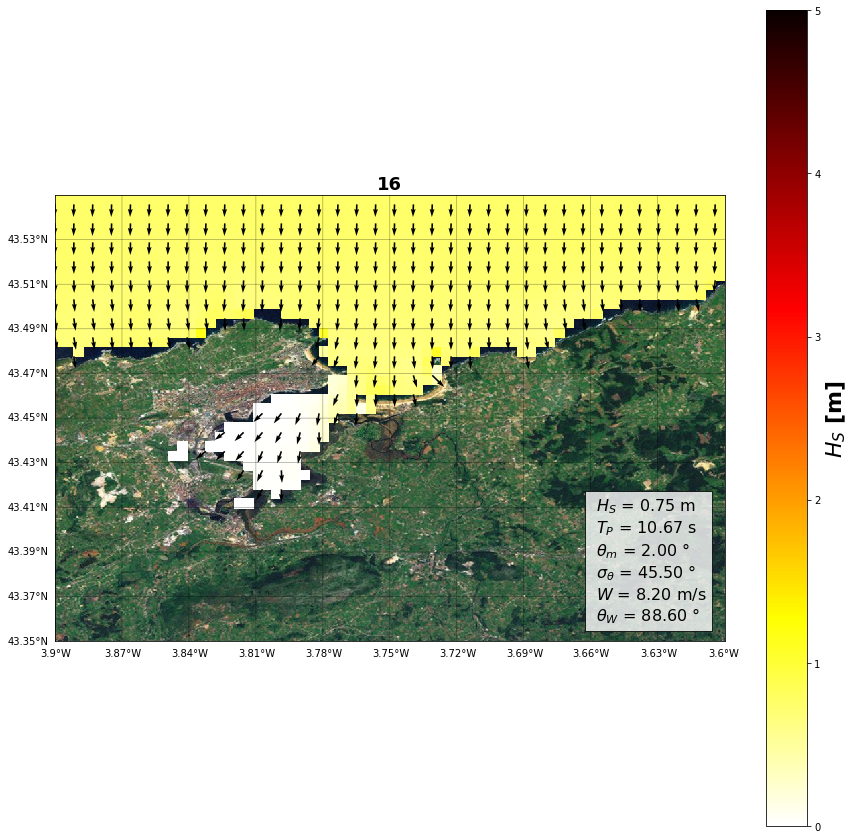

In [13]:
plt.figure(figsize=(15,15))

# Plot the Basemap
m = Basemap(llcrnrlon=ini_lon,  llcrnrlat=ini_lat, 
            urcrnrlon=end_lon, urcrnrlat=end_lat, 
            resolution='l')
 
# Then add element: draw coast line, map boundary, and fill continents:
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000) # becareful with adding xpixels
grid_step_lon = round(abs(end_lon - ini_lon) / 10, 3)
grid_step_lat = round(abs(end_lat - ini_lat) / 10, 3)
m.drawmeridians(np.arange(ini_lon, end_lon+grid_step_lon, grid_step_lon), 
                linewidth=0.5, labels=[1,0,0,1])
m.drawparallels(np.arange(ini_lat, end_lat+grid_step_lat, grid_step_lat), 
                linewidth=0.5, labels=[1,0,0,1])

waves_case = waves.iloc[case]
plt.title(str(case), fontsize=18, fontweight='bold')
# --------------------------------------------------------------------------- #
# Hsig
xx = np.linspace(ini_lon, end_lon, x_point)
yy = np.linspace(ini_lat, end_lat, y_point)
X, Y = np.meshgrid(xx, yy)
hsig = waves_propagated.sel(case=case).Hsig.values.T
P = plt.pcolor(X, Y, hsig, cmap='hot_r', vmin=0, vmax=5)
PC = plt.colorbar(P)
PC.set_label('$H_{S}$ [m]', fontsize=22, fontweight='bold')
# --------------------------------------------------------------------------- #
# Dir, Dspr and Tp
dir_step = 2 # not all arrows are plotted
xx = xx[::dir_step]
yy = yy[::dir_step]
X, Y = np.meshgrid(xx, yy)
dirr = waves_propagated.sel(case=case).Dir.values.T
dirr = (dirr*np.pi/180)[::dir_step,::dir_step]
perr = waves_propagated.sel(case=case).TPsmoo.values.T
perr = perr[::dir_step,::dir_step]
U = -(np.sin(dirr) * perr)
V = -(np.cos(dirr) * perr)
plt.quiver(X, Y, U, V, color='k')
plt.xticks([])
plt.yticks([])

textstr = '\n'.join((
        r' $H_S$ = %.2f m' % (waves_case['hs'], ),
        r' $T_P$ = %.2f s' % (waves_case['per'], ),
        r' $\theta _{m}$ = %.2f $\degree$' % (waves_case['dir'], ),
        r' $\sigma _\theta$ = %.2f $\degree$' % (waves_case['spr'], ),
        r' $W$ = %.2f m/s' % (waves_case['vel'], ),
        r' $\theta _{W}$ = %.2f $\degree$' % (waves_case['dirw'], )))
plt.text(0.8, 0.18, textstr, 
         {'color': 'k', 'fontsize': 16},
         horizontalalignment='left',
         verticalalignment='center',
         transform=plt.gca().transAxes,
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 6})

<div class="alert alert-block alert-info">
<b>Advice:</b> Restart the kernel now so the changed files (<code>make_input</code> function) can be reloaded correctly and the propagations of the swells can work.
</div>

## Swells can be run below

\begin{equation*}
\textit{Swells: } \:\: H_S \:\: T_P \:\: \theta_m \:\: \sigma_\theta \:\: \gamma
\end{equation*}

In [1]:
# common 
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from time import time

import warnings
warnings.filterwarnings("ignore")

t0 = time()

# swan wrap module
from lib.wrap import SwanProject, SwanWrap_STAT

In [2]:
# --------------------------------------------------------------------------- #
# data
num_cases = 20
p_data = op.abspath(op.join(os.getcwd(), '..', 'data'))
p_hind = op.join(p_data, 'hindcast')
waves = pd.read_pickle(op.join(p_hind, 'swell_cases_'+str(num_cases)+'.pkl'))

waves.rename(columns={'Hswell'   : 'hs',
                      'Tpswell'  : 'per',
                      'Dirswell' : 'dir',
                      'Sprswell' : 'spr',
                      'Gamma'    : 'gamma'}, inplace=True)

print(waves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hs      20 non-null     float64
 1   per     20 non-null     float64
 2   dir     20 non-null     float64
 3   spr     20 non-null     float64
 4   gamma   20 non-null     float64
dtypes: float64(5)
memory usage: 928.0 bytes
None


In [3]:
# --------------------------------------------------------------------------- #
# GRID PARAMETERS
# --------------------------------------------------------------------------- #
# ----------------  EDIT ONLY THIS PART  ------------------------------------ #
# --------------------------------------------------------------------------- #
name = 'CAN' # please choose a short name (max 3 letters)
# Coordinates section
# Place the coordinates as they are proportioned in Google Maps
ini_lon = -3.9
end_lon = -3.6
ini_lat = 43.35
end_lat = 43.55
# --------------------------------------------------------------------------- #
# ----------------  END EDIT  ----------------------------------------------- #

In [4]:
# --------------------------------------------------------------------------- #
# depth auto-selection
p_depth = op.join(p_data, 'bathymetry', 'gebco_2020_n44.0_s43.0_w-4.5_e-2.5.nc')
depth = xr.open_dataset(p_depth)
depth = depth.sel(lat=slice(ini_lat,end_lat)).sel(lon=slice(ini_lon,end_lon))
x_point = len(depth.lon.values)
y_point = len(depth.lat.values)
resolution = round(abs(end_lon - ini_lon) / x_point, 4)

### <font color=red>RUN THE SWELLS IN THE CELL BELOW</font>

In [5]:
# --------------------------------------------------------------------------- #
# SWAN project 
p_proj = op.join(p_data, 'projects-swan')    # swan projects main directory
n_proj = name + '-SWELL-' + str(resolution)  # project name

sp = SwanProject(p_proj, n_proj)

# depth grid description (input bathymetry grid)
sp.mesh_main.dg = {
    'xpc': ini_lon,            # x origin
    'ypc': ini_lat,            # y origin
    'alpc': 0,                 # x-axis direction 
    'xlenc': end_lon-ini_lon,  # grid length in x
    'ylenc': end_lat-ini_lat,  # grid length in y
    'mxc': x_point-1,          # number mesh x
    'myc': y_point-1,          # number mesh y
    'dxinp': resolution,       # size mesh x
    'dyinp': resolution,       # size mesh y
}

# depth swan init
sp.mesh_main.depth = - depth.elevation.values

# computational grid description
sp.mesh_main.cg = {
    'xpc': ini_lon,
    'ypc': ini_lat,
    'alpc': 0,
    'xlenc': end_lon-ini_lon,
    'ylenc': end_lat-ini_lat,
    'mxc': x_point,
    'myc': y_point,
    'dxinp': resolution,
    'dyinp': resolution,
}

# SWAN parameters (sea level, jonswap gamma)
sp.params = {
    'sea_level': 0,
    'cdcap': None,
    'coords_spherical': None,
    'waves_period': 'PEAK',
    'maxerr': None,
}

# SWAN wrap STAT (create case files, launch SWAN num. model, extract output)
sw = SwanWrap_STAT(sp)

# build stationary cases from waves data
sw.build_cases(waves)

# run SWAN
sw.run_cases()

# extract output from main mesh 
waves_propagated = sw.extract_output()

# save to netCDF file and cases propagated to dataframe
waves.to_pickle(op.join(p_proj, n_proj, 'swell_cases_'+str(num_cases)+'.pkl'))
waves_propagated.to_netcdf(op.join(p_proj, n_proj, 
                           'swell_propagated_'+str(num_cases)+'.nc'))

print('Time transcurred: ' + str(round((time()-t0)/3600, 2)) + ' h')

SWAN CASE: 0000 ---> hs   10.90, per   18.27, dir  290.00, spr   20.60
SWAN CASE: 0001 ---> hs    0.36, per    3.63, dir  113.00, spr   70.70
SWAN CASE: 0002 ---> hs    0.05, per   16.42, dir  294.00, spr    7.90
SWAN CASE: 0003 ---> hs    0.10, per    4.75, dir  110.00, spr   14.10
SWAN CASE: 0004 ---> hs    0.51, per   10.04, dir  288.00, spr   76.50
SWAN CASE: 0005 ---> hs    0.21, per    4.18, dir   34.00, spr   17.40
SWAN CASE: 0006 ---> hs    0.07, per    7.49, dir  292.00, spr    5.00
SWAN CASE: 0007 ---> hs    0.17, per    2.90, dir  295.00, spr   66.70
SWAN CASE: 0008 ---> hs    0.06, per   28.44, dir  278.00, spr    8.80
SWAN CASE: 0009 ---> hs    0.39, per    4.97, dir  168.00, spr    6.80
SWAN CASE: 0010 ---> hs    4.34, per   14.01, dir  289.00, spr   14.60
SWAN CASE: 0011 ---> hs    0.29, per    8.96, dir   45.00, spr   68.40
SWAN CASE: 0012 ---> hs    0.69, per    4.65, dir  167.00, spr   37.70
SWAN CASE: 0013 ---> hs    0.71, per    4.48, dir  219.00, spr   44.20
SWAN C

In [8]:
# Select the case to plot
case = 10

Text(0.8, 0.18, ' $H_S$ = 4.34 m\n $T_P$ = 14.01 s\n $\\theta _{m}$ = 289.00 $\\degree$\n $\\sigma _\\theta$ = 14.60 $\\degree$\n $\\gamma$ = 23.72')

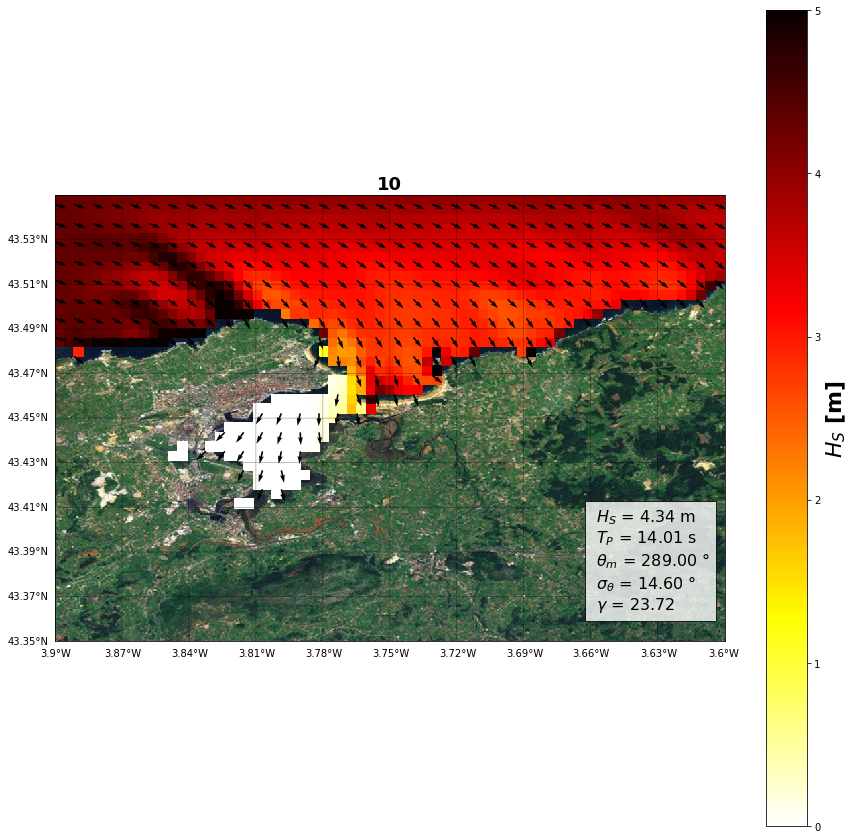

In [9]:
plt.figure(figsize=(15,15))

# Plot the Basemap
m = Basemap(llcrnrlon=ini_lon,  llcrnrlat=ini_lat, urcrnrlon=end_lon, urcrnrlat=end_lat, 
            resolution='l')
 
# Then add element: draw coast line, map boundary, and fill continents:
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000) # becareful with adding xpixels
grid_step_lon = round(abs(end_lon - ini_lon) / 10, 3)
grid_step_lat = round(abs(end_lat - ini_lat) / 10, 3)
m.drawmeridians(np.arange(ini_lon, end_lon+grid_step_lon, grid_step_lon), 
                linewidth=0.5, labels=[1,0,0,1])
m.drawparallels(np.arange(ini_lat, end_lat+grid_step_lat, grid_step_lat), 
                linewidth=0.5, labels=[1,0,0,1])

waves_case = waves.iloc[case]
plt.title(str(case), fontsize=18, fontweight='bold')
# --------------------------------------------------------------------------- #
# Hsig
xx = np.linspace(ini_lon, end_lon, x_point)
yy = np.linspace(ini_lat, end_lat, y_point)
X, Y = np.meshgrid(xx, yy)
hsig = waves_propagated.sel(case=case).Hsig.values.T
P = plt.pcolor(X, Y, hsig, cmap='hot_r', vmin=0, vmax=5)
PC = plt.colorbar(P)
PC.set_label('$H_{S}$ [m]', fontsize=22, fontweight='bold')
# --------------------------------------------------------------------------- #
# Dir, Dspr and Tp
dir_step = 2 # not all arrows are plotted
xx = xx[::dir_step]
yy = yy[::dir_step]
X, Y = np.meshgrid(xx, yy)
dirr = waves_propagated.sel(case=case).Dir.values.T
dirr = (dirr*np.pi/180)[::dir_step,::dir_step]
perr = waves_propagated.sel(case=case).TPsmoo.values.T
perr = perr[::dir_step,::dir_step]
U = -(np.sin(dirr) * perr)
V = -(np.cos(dirr) * perr)
plt.quiver(X, Y, U, V, color='k')
plt.xticks([])
plt.yticks([])

textstr = '\n'.join((
        r' $H_S$ = %.2f m' % (waves_case['hs'], ),
        r' $T_P$ = %.2f s' % (waves_case['per'], ),
        r' $\theta _{m}$ = %.2f $\degree$' % (waves_case['dir'], ),
        r' $\sigma _\theta$ = %.2f $\degree$' % (waves_case['spr'], ),
        r' $\gamma$ = %.2f' % (waves_case['gamma'], )))
plt.text(0.8, 0.18, textstr, 
         {'color': 'k', 'fontsize': 16},
         horizontalalignment='left',
         verticalalignment='center',
         transform=plt.gca().transAxes,
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 6})

If you have reached this cell without errors, then the cases have been run correctly and the saved data is stored in data/projects-swan. If an error has occured, you can also have a look at the _Error output file_ in the case's folders, and also the issues section is available in the repository for this purpose. Be careful with the saving of the data, as new propagations saved with the same name as previously ones can make conflict, so delete the old propagations if they are not neccessary.

The propagated files will be used in the reconstruction step (RBF) so please be sure they have been correctly generated.